# Content-based book recommendation

In [52]:
# Import library
import glob

# The books files are contained in this folder
folder = "/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/"

# List all the .txt files and sort them alphabetically
files = glob.glob(folder + "*.txt")
# soting
files.sort()
files

['/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/Autobiography.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/CoralReefs.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/DescentofMan.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/DifferentFormsofFlowers.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/EffectsCrossSelfFertilization.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/ExpressionofEmotionManAnimals.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/FormationVegetableMould.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book recommendation/Data set/FoundationsOriginofSpecies.txt',
 '/Users/kienguyen/Documents/DATA SCIENCE/Personal projects/Book re

### Load the contents of each book

In [53]:
# Import libraries
import re, os

# Initialize the object that will contain the texts and titles
txts = []
titles = []

for n in files:
    # Open each file
    f = open(n, encoding='utf-8-sig')
    # Remove all non-alpha-numeric characters
    data = re.sub('[\W_]+',' ',f.read())
    # Store the texts and titles of the books in two separate lists
    txts.append(data)
    titles.append(os.path.basename(n).replace('.txt',''))

# Print the length, in characters, of each book
[len(t) for t in txts]

[123231,
 496068,
 1776539,
 617088,
 913713,
 624232,
 335920,
 523021,
 797401,
 901406,
 1047518,
 1010643,
 767492,
 1660866,
 298319,
 916267,
 1093567]

### List of the books in dataset

In [54]:
titles

['Autobiography',
 'CoralReefs',
 'DescentofMan',
 'DifferentFormsofFlowers',
 'EffectsCrossSelfFertilization',
 'ExpressionofEmotionManAnimals',
 'FormationVegetableMould',
 'FoundationsOriginofSpecies',
 'GeologicalObservationsSouthAmerica',
 'InsectivorousPlants',
 'LifeandLettersVol1',
 'LifeandLettersVol2',
 'MonographCirripedia',
 'MonographCirripediaVol2',
 'MovementClimbingPlants',
 'OriginofSpecies',
 'PowerMovementPlants']

### The "DescentofMan" book is the target of the recommendation

In [55]:
# Browse the list containing all the titles
des=0
for i in range(len(titles)):
    # Store the index if the title is "DescentofMan"
    if(titles[i]=="DescentofMan"):
        des = i

# Print the stored index
print(str(des))

2


### Tokenize the corpus

In [56]:
# Create list of stop words
from nltk.corpus import stopwords
stops = stopwords.words('english')

# Convert the text to lower case 
txts_lower_case = [txt.lower() for txt in txts]

# Transform the text into tokens 
txts_split = [txt.split() for txt in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[word for word in txt if word not in stops] for txt in txts_split]

# Print the first 20 tokens for the "Descent of Man" book
texts[des][0:20]

['descent',
 'man',
 'selection',
 'relation',
 'sex',
 'works',
 'charles',
 'darwin',
 'f',
 'r',
 'life',
 'letters',
 'charles',
 'darwin',
 'autobiographical',
 'chapter',
 'edited',
 'francis',
 'darwin',
 'portraits']

### Stemming process
This process will convert inflected forms of a word into a single item

In [57]:
import pickle
# Load the Porter stemming function from the nltk package
from nltk.stem import PorterStemmer

# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Save to pickle file
pickle.dump( texts_stem, open( folder+"texts_stem.p", "wb" ) )

In [58]:
# Load the stemmed tokens list from the pickle file
texts_stem = pickle.load(open( folder+"texts_stem.p", "rb" ))

# Print the 20 first stemmed tokens from the "On the Origin of Species" book
texts_stem[des][0:20]

['descent',
 'man',
 'select',
 'relat',
 'sex',
 'work',
 'charl',
 'darwin',
 'f',
 'r',
 'life',
 'letter',
 'charl',
 'darwin',
 'autobiograph',
 'chapter',
 'edit',
 'franci',
 'darwin',
 'portrait']

### Use the bag-of-words model to extract unique words and their respective number of occurrences to prepare data for TF-IDF model

In [59]:
from gensim import corpora

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows =  [dictionary.doc2bow(text) for text in texts_stem]

# Print the first five elements of the 'Descent of Man' BoW model
bows[des][0:5]

[(0, 58), (5, 35), (6, 38), (8, 27), (9, 4)]

In [60]:
import pandas as pd

# Convert the BoW model for "Descent of Man" into a DataFrame
df_bow_des = pd.DataFrame(bows[des])

# Add the column names to the DataFrame
df_bow_des.columns = ['index','occurrences']

# Add a column containing the token corresponding to the dictionary index
df_bow_des['token'] = [dictionary[index] for index in df_bow_des['index']]

# Sort the DataFrame by descending number of occurrences and print the first 10 values
df_bow_des.sort_values(by='occurrences', ascending = False).head(10)

,index,occurrences,token
1143,1480,2867,male
5931,7823,2135,femal
362,493,1445,colour
515,681,1407,differ
1652,2124,1326,sex
1328,1717,1324,p
1145,1483,1218,man
244,310,1103,bird
1731,2223,1100,speci
1299,1684,999,one


### Build a tf-idf model
The purpose of this model is to identify the relative words

In [61]:
# Load the gensim functions that will allow us to generate tf-idf models
from gensim.models import TfidfModel

# Generate the tf-idf model
model = TfidfModel(bows)

# Print the model for "Descent of Man"
model[bows[des]]

[(9, 0.0015547337315509886),
 (11, 0.0011660502986632413),
 (12, 0.0010721503957755601),
 (13, 0.0019811397958146965),
 (14, 0.0016509498298455801),
 (15, 0.00272078403021423),
 (17, 0.00038868343288774715),
 (18, 0.0005571901431652603),
 (19, 0.0015255297020261508),
 (20, 0.0027893023900565027),
 (21, 0.0018802099271993085),
 (22, 0.0009154551165060241),
 (23, 0.0018595349267043352),
 (24, 0.0028603681912990325),
 (25, 0.0005482775261992988),
 (26, 0.002288294553039226),
 (27, 0.00085050100838009),
 (28, 0.002478985765792495),
 (29, 0.0013731826747590363),
 (30, 0.0023321005973264827),
 (31, 0.0024412136440160647),
 (32, 0.0009905698979073483),
 (33, 0.004457521145322082),
 (34, 0.0037190698534086703),
 (35, 0.0046488373167608375),
 (36, 0.003623133042312108),
 (37, 0.005943419387444089),
 (38, 0.010586612720139946),
 (39, 0.038817791594953),
 (40, 0.011250781552442862),
 (41, 0.009153178212156905),
 (42, 0.004195206680571915),
 (44, 0.0005571901431652603),
 (51, 0.0008225918431496974

In [62]:
# Convert the tf-idf model for "Descent of Man" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[des]])

# Name the columns of the DataFrame id and score
df_tfidf.columns=["id", "score"]

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [dictionary[i] for i in list(df_tfidf["id"])]

# Sort the DataFrame by descending tf-idf score and print the first 10 rows.
df_tfidf.sort_values(by="score", ascending=False).head(10)

,id,score,token
5303,7823,0.496263,femal
801,1480,0.437435,male
8318,10838,0.207262,shew
7564,10084,0.171544,plumag
1151,2124,0.155822,sex
8319,10839,0.134056,shewn
1152,2125,0.116721,sexual
8600,11120,0.105618,stridul
65,121,0.100669,adult
6861,9381,0.094839,monkey


### Compute distance between texts

In [63]:
# Load the library allowing similarity computations
from gensim import similarities

# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a DataFrame
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the DataFrame
sim_df.columns = titles
sim_df.index = titles

# Print the resulting matrix
sim_df

,Autobiography,CoralReefs,DescentofMan,DifferentFormsofFlowers,EffectsCrossSelfFertilization,ExpressionofEmotionManAnimals,FormationVegetableMould,FoundationsOriginofSpecies,GeologicalObservationsSouthAmerica,InsectivorousPlants,LifeandLettersVol1,LifeandLettersVol2,MonographCirripedia,MonographCirripediaVol2,MovementClimbingPlants,OriginofSpecies,PowerMovementPlants
Autobiography,1.000000,0.057767,0.078812,0.055780,0.063278,0.087811,0.038032,0.068213,0.032073,0.012777,0.547387,0.300357,0.005671,0.008437,0.022725,0.100397,0.014529
CoralReefs,0.057767,1.000000,0.010383,0.002280,0.002323,0.005277,0.030925,0.026576,0.061461,0.002593,0.048840,0.028706,0.007695,0.012086,0.001581,0.043986,0.002988
DescentofMan,0.078812,0.010383,1.000000,0.078194,0.029291,0.154909,0.027487,0.141544,0.010633,0.009390,0.086014,0.119482,0.057480,0.045837,0.005336,0.258626,0.012233
DifferentFormsofFlowers,0.055780,0.002280,0.078194,1.000000,0.360926,0.006524,0.012467,0.043347,0.003206,0.008566,0.022496,0.068388,0.010147,0.006143,0.009258,0.122782,0.019283
EffectsCrossSelfFertilization,0.063278,0.002323,0.029291,0.360926,1.000000,0.006687,0.037423,0.043914,0.002439,0.007735,0.026631,0.065829,0.003525,0.003355,0.017183,0.138641,0.044045
ExpressionofEmotionManAnimals,0.087811,0.005277,0.154909,0.006524,0.006687,1.000000,0.020848,0.053137,0.005479,0.010876,0.091347,0.074972,0.018771,0.030589,0.006471,0.067321,0.012345
FormationVegetableMould,0.038032,0.030925,0.027487,0.012467,0.037423,0.020848,1.000000,0.024674,0.074045,0.037370,0.041933,0.035501,0.022711,0.026799,0.047564,0.052485,0.047369
FoundationsOriginofSpecies,0.068213,0.026576,0.141544,0.043347,0.043914,0.053137,0.024674,1.000000,0.033071,0.006928,0.093707,0.087711,0.008776,0.012216,0.004502,0.352024,0.009464
GeologicalObservationsSouthAmerica,0.032073,0.061461,0.010633,0.003206,0.002439,0.005479,0.074045,0.033071,1.000000,0.007732,0.043066,0.018148,0.010551,0.025859,0.002176,0.058964,0.003729
InsectivorousPlants,0.012777,0.002593,0.009390,0.008566,0.007735,0.010876,0.037370,0.006928,0.007732,1.000000,0.008621,0.025225,0.020189,0.020648,0.226982,0.015059,0.026295


### The most similar book to "Descent of Man"

Text(0.5, 1.0, "Most similar books to 'Descent of Man'")

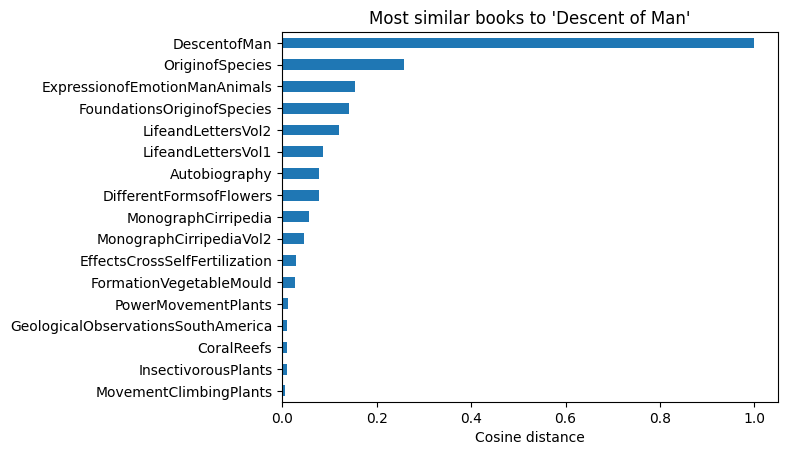

In [64]:
# This is needed to display plots in a notebook
%matplotlib inline

# Import the needed functions from matplotlib
import matplotlib.pyplot as plt

# Select the column corresponding to "Descent of Man" and 
v = sim_df["DescentofMan"]

# Sort by ascending scores
v_sorted = v.sort_values(ascending=True)

# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

# Modify the axes labels and plot title for better readability
plt.xlabel("Cosine distance")
plt.ylabel("")
plt.title("Most similar books to 'Descent of Man'")


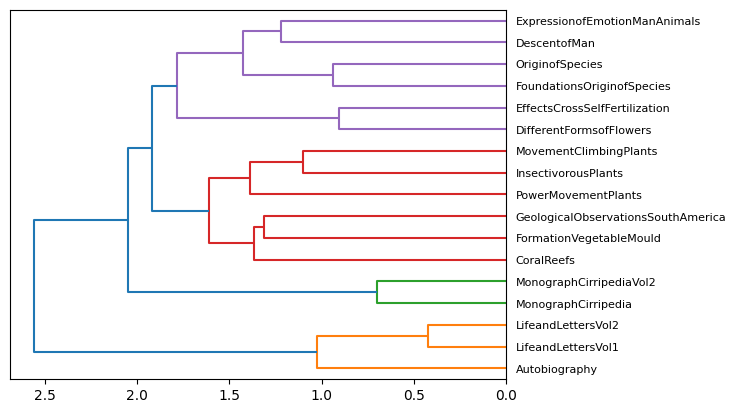

In [65]:
# Import libraries
from scipy.cluster import hierarchy

# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')

# Display this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z,  leaf_font_size=8, labels=sim_df.index,  orientation="left")